In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir('gdrive/Shared drives/CIS680Group/hw4/PartB')

!pip install pytorch_lightning

Mounted at /content/gdrive
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 132 kB 74.9 MB/s 
     |████████████████████████████████| 596 kB 48.7 MB/s 
     |████████████████████████████████| 329 kB 74.7 MB/s 
     |████████████████████████████████| 829 kB 32.2 MB/s 
     |████████████████████████████████| 1.1 MB 70.3 MB/s 
     |████████████████████████████████| 271 kB 72.3 MB/s 
     |████████████████████████████████| 192 kB 71.7 MB/s 
     |████████████████████████████████| 160 kB 69.6 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=26a03936d5a6bf12f4672d1c5389e8683cae756e1fdd72b0b6d38948d57c9f37
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting unins

In [ ]:
import numpy as np
import h5py

with h5py.File('Dataset/hw3_mycocodata_img_comp_zlib.h5', 'r') as f:
  images = f['data'][()]

labels = np.load('Dataset/hw3_mycocodata_labels_comp_zlib.npy', allow_pickle=True)
bounding_boxes = np.load('Dataset/hw3_mycocodata_bboxes_comp_zlib.npy', allow_pickle=True)

In [ ]:
import pytorch_lightning as pl
import torch
from torch import nn
import torchvision

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [ ]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import h5py
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from dataset import *
from pretrained_models import *

# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
def collate_fn(batch):
    images, labels, bounding_boxes = list(zip(*batch))
    return torch.stack(images), labels, bounding_boxes

train_dataset = COCODataset(images[:2540], labels[:2540], bounding_boxes[:2540])
val_dataset = COCODataset(images[2540:], labels[2540:], bounding_boxes[2540:])
train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn, shuffle=False)

In [ ]:
from torchvision.ops import roi_align
from torchvision.models.detection.image_list import ImageList

class BoxHead(pl.LightningModule):
  def __init__(self,Classes=3,P=7):
    super().__init__()
    self.C=Classes
    self.P=P
    self.intermediate1 = nn.Linear(256*self.P**2, 1024)
    self.intermediate2 = nn.Linear(1024, 1024)
    self.classifier = nn.Linear(1024, self.C+1)
    self.regressor = nn.Linear(1024, self.C*4)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)
    self.loss_ce = nn.CrossEntropyLoss()
    self.l1_loss = nn.SmoothL1Loss()

    pretrained_path='checkpoint680.pth'
    self.backbone, self.rpn = pretrained_models_680(pretrained_path)

    for param in self.backbone.parameters():
      param.requires_grad = False

    for param in self.rpn.parameters():
      param.requires_grad = False

    self.train_losses = []
    self.val_losses = []

  #  This function assigns to each proposal either a ground truth box or the background class (we assume background class is 0)
  #  Input:
  #       proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
  #       gt_labels: list:len(bz) {(n_obj)}
  #       bbox: list:len(bz){(n_obj, 4)}
  #  Output: (make sure the ordering of the proposals are consistent with MultiScaleRoiAlign)
  #       labels: (total_proposals,1) (the class that the proposal is assigned)
  #       regressor_target: (total_proposals,4) (target encoded in the [t_x,t_y,t_w,t_h] format)
  def create_ground_truth(self,proposals,gt_labels,bbox):
    batch_size = len(gt_labels)
    labels_temp = []
    regressor_target_temp = []
    keep_topK = proposals[0].shape[0]
    for b in range(batch_size):
      proposal_batch = proposals[b].cpu().numpy()
      class_batch = gt_labels[b]
      bbox_batch = bbox[b]
      label_batch = []
      target_batch = []
      cx = (proposal_batch[:,0]+proposal_batch[:,2])/2
      cy = (proposal_batch[:,1]+proposal_batch[:,3])/2
      w = proposal_batch[:,2]-proposal_batch[:,0]
      h = proposal_batch[:,3]-proposal_batch[:,1]
      proposals_new = [cx, cy, w, h]
      proposals_new = np.concatenate([np.expand_dims(x, axis=1) for x in proposals_new], axis=1)
      cx = (bbox_batch[:,0]+bbox_batch[:,2])/2
      cy = (bbox_batch[:,1]+bbox_batch[:,3])/2
      w = bbox_batch[:,2]-bbox_batch[:,0]
      h = bbox_batch[:,3]-bbox_batch[:,1]
      bbox_new = [cx, cy, w, h]
      bbox_new = np.concatenate([np.expand_dims(x, axis=1) for x in bbox_new], axis=1)
      for box in range(proposals_new.shape[0]):
        iou = IOU(proposals_new[box,:], bbox_new)
        matches = np.nonzero(iou > 0.5)[0]
        if len(matches) > 0:
          match = np.argmax(iou)
          label_batch.append(class_batch[match])
          match_box = bbox_new[match]
          tx = (match_box[0]-proposals_new[box,0])/proposals_new[box,2]
          ty = (match_box[1]-proposals_new[box,1])/proposals_new[box,3]
          tw = np.log(match_box[2]/proposals_new[box,2])
          th = np.log(match_box[3]/proposals_new[box,3])
          tgt_encoded = np.array([tx, ty, tw, th])
          target_batch.append(np.expand_dims(tgt_encoded, axis=0))
        else:
          label_batch.append(0)
          target_batch.append(np.ones((1, 4)))
      label_batch = np.array(label_batch)
      target_batch = np.concatenate(target_batch, axis=0)
      labels_temp.append(label_batch)
      regressor_target_temp.append(target_batch)
    labels = torch.tensor(np.concatenate(labels_temp), device=device)
    regressor_target = torch.tensor(np.concatenate(regressor_target_temp, axis=0), device=device)

    return labels, regressor_target

  # This function for each proposal finds the appropriate feature map to sample and using RoIAlign it samples
  # a (256,P,P) feature map. This feature map is then flattened into a (256*P*P) vector
  # Input:
  #      fpn_feat_list: list:len(FPN){(bz,256,H_feat,W_feat)}
  #      proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
  #      P: scalar
  # Output:
  #      feature_vectors: (total_proposals, 256*P*P)  (make sure the ordering of the proposals are the same as the ground truth creation)
  def MultiScaleRoiAlign(self, fpn_feat_list,proposals,P=7):
    batch_size = len(proposals)
    feature_vectors = []
    for b in range(batch_size):
      fpn_dict = {2: [], 3: [], 4: [], 5: []}
      idx_batch = np.zeros(proposals[b].shape[0])
      idx_batch_dict = {2: [], 3: [], 4: [], 5: []}
      proposal_batch = proposals[b]
      w = proposal_batch[:,2]-proposal_batch[:,0]
      h = proposal_batch[:,3]-proposal_batch[:,1]
      k = torch.floor(4 + torch.log2(torch.sqrt(w*h)/224)).int()
      k[k < 2] = 2
      k[k > 5] = 5
      for box in range(proposal_batch.shape[0]):
        fpn_dict[k[box].item()].append(proposal_batch[box].unsqueeze(0))
        idx_batch_dict[k[box].item()].append(box)
      for key in [2, 3, 4, 5]:
        if len(fpn_dict[key]) > 0:
          fpn_dict[key] = torch.cat(fpn_dict[key], dim=0)
          idx_batch_dict[key] = np.array(idx_batch_dict[key])
        else:
          fpn_dict[key] = torch.zeros((0, 4), device=device)
      idx = np.concatenate([idx_batch_dict[k] for k in [2, 3, 4, 5]])
      for box in range(proposal_batch.shape[0]):
        idx_batch[box] = np.nonzero(idx == box)[0][0]

      p2_pools = torch.flatten(roi_align(fpn_feat_list[0][b].unsqueeze(0), [fpn_dict[2]], P, spatial_scale=0.25), start_dim=1)
      p3_pools = torch.flatten(roi_align(fpn_feat_list[1][b].unsqueeze(0), [fpn_dict[3]], P, spatial_scale=0.125), start_dim=1)
      p4_pools = torch.flatten(roi_align(fpn_feat_list[2][b].unsqueeze(0), [fpn_dict[4]], P, spatial_scale=0.0625), start_dim=1)
      p5_pools = torch.flatten(roi_align(fpn_feat_list[3][b].unsqueeze(0), [fpn_dict[5]], P, spatial_scale=0.03125), start_dim=1)
      feature_vector = torch.cat([p2_pools, p3_pools, p4_pools, p5_pools], dim=0)
      feature_vector = feature_vector[idx_batch,:]
      feature_vectors.append(feature_vector)

    feature_vectors = torch.cat(feature_vectors, dim=0)

    return feature_vectors

  # This function does the post processing for the results of the Box Head for a batch of images
  # Use the proposals to distinguish the outputs from each image
  # Input:
  #       class_logits: (total_proposals,(C+1))
  #       box_regression: (total_proposal,4*C)           ([t_x,t_y,t_w,t_h] format)
  #       proposals: list:len(bz)(per_image_proposals,4) (the proposals are produced from RPN [x1,y1,x2,y2] format)
  #       conf_thresh: scalar
  #       keep_num_preNMS: scalar (number of boxes to keep pre NMS)
  #       keep_num_postNMS: scalar (number of boxes to keep post NMS)
  # Output:
  #       boxes: list:len(bz){(post_NMS_boxes_per_image,4)}  ([x1,y1,x2,y2] format)
  #       scores: list:len(bz){(post_NMS_boxes_per_image)}   ( the score for the top class for the regressed box)
  #       labels: list:len(bz){(post_NMS_boxes_per_image)}   (top class of each regressed box)
  def postprocess_detections(self, class_logits, box_regression, proposals, conf_thresh=0.5, keep_num_preNMS=50, keep_num_postNMS=2):
    bz = len(proposals)
    per_image_proposals = 200
    boxes = []
    scores = []
    labels = []
    for b in range(bz):
      proposals_batch = proposals[b].detach().cpu().numpy()
      logits_batch = class_logits[b*per_image_proposals:(b+1)*per_image_proposals,:].detach().cpu().numpy()
      regr_batch = box_regression[b*per_image_proposals:(b+1)*per_image_proposals,:].detach().cpu().numpy()
      box_sample, score_sample, label_sample = self.postprocess_sample(logits_batch, regr_batch, proposals_batch, conf_thresh, keep_num_preNMS, keep_num_postNMS)
      boxes.append(box_sample)
      scores.append(score_sample)
      labels.append(label_sample)
    return boxes, scores, labels

  def postprocess_sample(self, logits, regr, proposals, conf_thresh, keep_preNMS, keep_num_postNMS):
    scores = np.max(logits, axis=1)
    labels = np.argmax(logits, axis=1)
    idx_to_keep = np.logical_and(scores > conf_thresh, labels > 0)
    scores = scores[idx_to_keep]
    boxes = regr[idx_to_keep]
    labels = labels[idx_to_keep]
    proposals = proposals[idx_to_keep]
    boxes_decoded = np.zeros((len(labels), 4))
    for i in range(len(labels)):
      l = labels[i]
      boxes_decoded[i,:] = boxes[i,(l-1)*4:l*4]
    boxes = output_decoding(boxes_decoded, proposals)

    boxes[boxes[:,0] < 0, 0] = 0
    boxes[boxes[:,1] < 0, 1] = 0
    boxes[boxes[:,2] > 1088, 2] = 1088
    boxes[boxes[:,3] > 800, 3] = 800
    K = min(keep_preNMS, len(scores))
    sorted_idx = np.argsort(scores)[::-1]
    top_k_idx = sorted_idx[:K]
    scores = scores[top_k_idx]
    boxes = boxes[top_k_idx,:]
    labels = labels[top_k_idx]

    scores_nms, boxes_nms, labels_nms = self.NMS(scores, boxes, labels)

    N = min(keep_num_postNMS, len(scores_nms))
    sorted_idx = np.argsort(scores_nms)[::-1]
    top_n_idx = sorted_idx[:N]
    scores_nms = scores_nms[top_n_idx]
    boxes_nms = boxes_nms[top_n_idx,:]
    labels_nms = labels_nms[top_n_idx]
    return boxes_nms, scores_nms, labels_nms
  
  # Compute the total loss of the classifier and the regressor
  # Input:
  #      class_logits: (total_proposals,(C+1)) (as outputed from forward, not passed from softmax so we can use CrossEntropyLoss)
  #      box_preds: (total_proposals,4*C)      (as outputed from forward)
  #      labels: (total_proposals,1)
  #      regression_targets: (total_proposals,4)
  #      l: scalar (weighting of the two losses)
  #      effective_batch: scalar
  # Outpus:
  #      loss: scalar
  #      loss_class: scalar
  #      loss_regr: scalar
  def compute_loss(self,class_logits, box_preds, labels, regression_targets,l=5,effective_batch=100):
    num_pos = min(int(0.75*effective_batch), torch.sum(labels > 0).item())
    num_neg = effective_batch - num_pos
    pos_idx = torch.nonzero(labels>0)[:,0]
    pos_idx = pos_idx[np.random.choice(np.arange(len(pos_idx)), size=num_pos, replace=False)]
    neg_idx = torch.nonzero(labels==0)[:,0]
    neg_idx = neg_idx[np.random.choice(np.arange(len(neg_idx)), size=num_neg, replace=False)]
    p_out = class_logits[pos_idx,:]
    p_true = labels[pos_idx]
    n_out = class_logits[neg_idx,:]
    n_true = labels[neg_idx]
    out = torch.cat([p_out, n_out], dim=0)
    true = torch.cat([p_true, n_true])
    loss_class = self.loss_ce(out, true)
    p_preds = box_preds[pos_idx,:]
    p_targ = regression_targets[pos_idx,:]
    loss_regr = 0
    for c in range(1, self.C+1):
      loss_c = 0
      class_idx = torch.nonzero(p_true == c)[:,0]
      num_c = len(class_idx)
      if num_c > 0:
        for i in range(4):
          val = self.l1_loss(p_preds[class_idx, (c-1)*4+i], p_targ[class_idx, i])
          loss_c += val*num_c
      loss_regr += loss_c
    loss_regr /= num_pos
    loss = loss_class + l*loss_regr
    return loss, loss_class, loss_regr

  # Forward the pooled feature vectors through the intermediate layer and the classifier, regressor of the box head
  # Input:
  #        feature_vectors: (total_proposals, 256*P*P)
  # Outputs:
  #        class_logits: (total_proposals,(C+1)) (we assume classes are C classes plus background, notice if you want to use
  #                                               CrossEntropyLoss you should not pass the output through softmax here)
  #        box_pred:     (total_proposals,4*C)
  def forward(self, feature_vectors):
    out = self.relu(self.intermediate1(feature_vectors))
    out = self.relu(self.intermediate2(out))
    class_logits = self.softmax(self.classifier(out))
    box_pred = self.regressor(out)
    return class_logits, box_pred
  
  def training_step(self, batch, batch_idx):
    keep_topK = 200
    self.rpn.eval()
    self.backbone.eval()
    images, labels, bounding_boxes = batch
    backout = self.backbone(images.float())
    im_lis = ImageList(images.float(), [(800, 1088)]*images.shape[0])
    rpnout = self.rpn(im_lis, backout)
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
    fpn_feat_list= list(backout.values())
    feature_vectors = self.MultiScaleRoiAlign(fpn_feat_list, proposals)
    class_logits, box_pred = self.forward(feature_vectors)
    gt_labels, regressor_target = self.create_ground_truth(proposals, labels, bounding_boxes)
    loss, loss_c, loss_r = self.compute_loss(class_logits, box_pred, gt_labels, regressor_target.float())
    self.log("train_loss", loss, prog_bar=True)
    self.log("train_class_loss", loss_c, prog_bar=True)
    self.log("train_regr_loss", loss_r, prog_bar=True)

    return {"loss": loss, "loss_c": loss_c, "loss_r": loss_r}
  
  def validation_step(self, batch, batch_idx):
    keep_topK = 200
    self.rpn.eval()
    self.backbone.eval()
    images, labels, bounding_boxes = batch
    backout = self.backbone(images.float())
    im_lis = ImageList(images.float(), [(800, 1088)]*images.shape[0])
    rpnout = self.rpn(im_lis, backout)
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
    fpn_feat_list= list(backout.values())
    feature_vectors = self.MultiScaleRoiAlign(fpn_feat_list, proposals)
    class_logits, box_pred = self.forward(feature_vectors)
    gt_labels, regressor_target = self.create_ground_truth(proposals, labels, bounding_boxes)
    loss, loss_c, loss_r = self.compute_loss(class_logits, box_pred, gt_labels, regressor_target.float())
    self.log("val_loss", loss, prog_bar=True)
    self.log("val_class_loss", loss_c, prog_bar=True)
    self.log("val_regr_loss", loss_r, prog_bar=True)

    return {"loss": loss, "loss_c": loss_c, "loss_r": loss_r}
  
  def training_epoch_end(self, outputs):
    loss = torch.tensor([output["loss"] for output in outputs]).mean().item()
    loss_c = torch.tensor([output["loss_c"] for output in outputs]).mean().item()
    loss_r = torch.tensor([output["loss_r"] for output in outputs]).mean().item()
    self.train_losses.append((loss, loss_c, loss_r))

    # Input:
    #       clas: (top_k_boxes) (scores of the top k boxes)
    #       prebox: (top_k_boxes,4) (coordinate of the top k boxes)
    # Output:
    #       nms_clas: (Post_NMS_boxes)
    #       nms_prebox: (Post_NMS_boxes,4)
  def NMS(self,scores, boxes, labels):
    sorted_prediction = np.concatenate([np.expand_dims(scores, axis=1), np.expand_dims(labels, axis=1), boxes], axis=1)
    postprocessed_prediction = []
    remaining_prediction = sorted_prediction
    while remaining_prediction.shape[0] > 0:
      current = remaining_prediction[0,:]
      remaining_prediction = remaining_prediction[1:,:]
      postprocessed_prediction.append(np.expand_dims(current, axis=0))
      if remaining_prediction.shape[0] == 0:
        break
      current_class = current[1]
      intersect_x_min = np.maximum(current[2], remaining_prediction[:,2])
      intersect_y_min = np.maximum(current[3], remaining_prediction[:,3])
      intersect_x_max = np.minimum(current[4], remaining_prediction[:,4])
      intersect_y_max = np.minimum(current[5], remaining_prediction[:,5])
      intersect = (intersect_x_max - intersect_x_min) * (intersect_y_max - intersect_y_min)
      invalid_idx = np.logical_or(intersect_x_max < intersect_x_min, intersect_y_max < intersect_y_min)
      area = (remaining_prediction[:,4]-remaining_prediction[:,2]) * (remaining_prediction[:,5]-remaining_prediction[:,3])
      current_area = (current[4]-current[2]) * (current[5]-current[3])
      union = current_area + area - intersect
      iou = intersect / union
      iou[invalid_idx] = 0
      iou[union==0] = 0
      idx = np.logical_not(np.logical_and(iou > 0.5, remaining_prediction[:,1]==current_class))
      remaining_prediction = remaining_prediction[idx, :]
  
    if len(postprocessed_prediction) == 0:
      output = np.zeros((0, 6))
      return output[:,0], output[:,2:], output[:,1]
  
    output = np.concatenate(postprocessed_prediction, axis=0)
    
    return output[:,0], output[:,2:], output[:,1]
    
  def validation_epoch_end(self, outputs):
    loss = torch.tensor([output["loss"] for output in outputs]).mean().item()
    loss_c = torch.tensor([output["loss_c"] for output in outputs]).mean().item()
    loss_r = torch.tensor([output["loss_r"] for output in outputs]).mean().item()
    self.val_losses.append((loss, loss_c, loss_r))
  
  def configure_optimizers(self):
    opt = torch.optim.Adam(self.parameters(), lr=5e-4)
    sched = {"scheduler": torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[20], gamma=0.1)}
    return {"optimizer": opt, "lr_scheduler": sched}

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


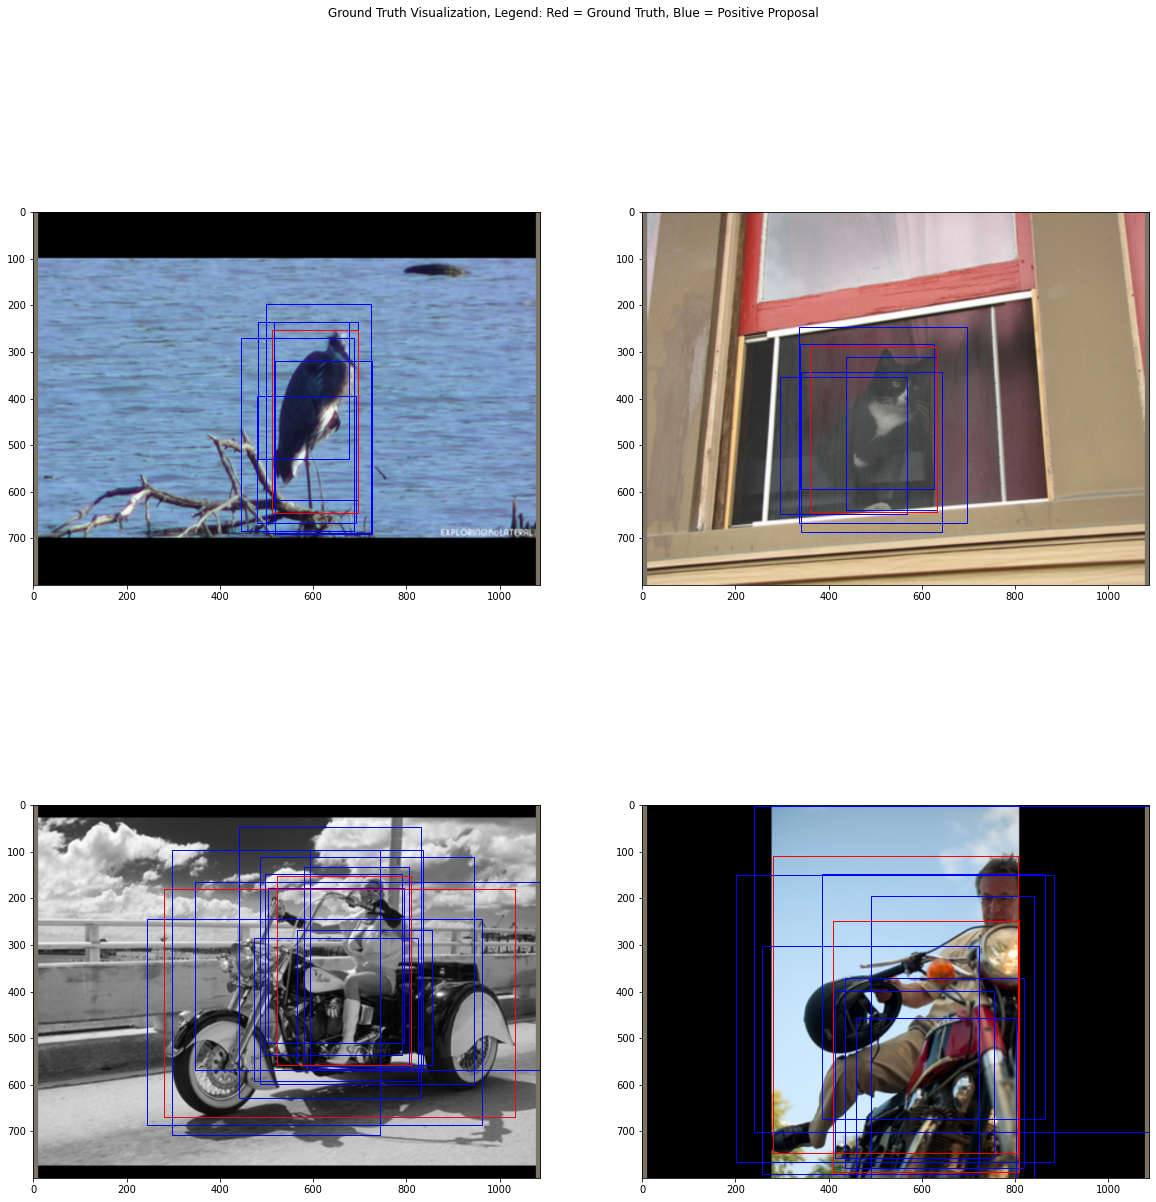

In [ ]:
# GROUND TRUTH VISUALIZATION
import logging
from torchvision.models.detection.image_list import ImageList
from matplotlib.patches import Rectangle

model = BoxHead().to(device)
keep_topK=20
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
cmap = {1: 'r', 2: 'g', 3: 'b'}
plt.figure(figsize=(20, 20))
with torch.no_grad():
  for i, batch in enumerate(val_loader):
    img_batch, label_batch, bbox_batch = batch
    img_batch = img_batch.to(device)
    # Take the features from the backbone
    backout = model.backbone(img_batch.float())
    # The RPN implementation takes as first argument the following image list
    im_lis = ImageList(img_batch.float(), [(800, 1088)]*img_batch.shape[0])
    # Then we pass the image list and the backbone output through the rpn
    rpnout = model.rpn(im_lis, backout)

    #The final output is
    # A list of proposal tensors: list:len(bz){(keep_topK,4)}
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
    
    # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
    gt_labels, regressor_target = model.create_ground_truth(proposals, label_batch, bbox_batch)
    gt_labels = gt_labels.cpu().numpy()
    regressor_target = regressor_target.cpu().numpy()
    flatten_proposals = np.concatenate([x.cpu().numpy() for x in proposals], axis=0)

    boxes = output_decoding(regressor_target, flatten_proposals)

    batch_size = len(label_batch)

    for b in range(batch_size):
      img_to_display = transforms.functional.normalize(img_batch[b],[-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225], inplace=False).permute(1,2,0)
      ax = plt.subplot(2, 2, b+1)
      ax.imshow(img_to_display.cpu())
      boxes_batch = boxes[b*keep_topK:(b+1)*keep_topK,:]
      gt_labels_batch = gt_labels[b*keep_topK:(b+1)*keep_topK]
      for j in range(keep_topK):
        if gt_labels_batch[j] > 0:
          w = boxes_batch[j, 2]-boxes_batch[j,0]
          h = boxes_batch[j,3]-boxes_batch[j,1]
          rect = Rectangle((boxes_batch[j,0], boxes_batch[j,1]), w, h, edgecolor='r', facecolor=None, fill=False)
          ax.add_patch(rect)
          w = proposals[b][j, 2]-proposals[b][j,0]
          h = proposals[b][j,3]-proposals[b][j,1]
          rect = Rectangle((proposals[b][j,0], proposals[b][j,1]), w, h, edgecolor='b', facecolor=None, fill=False)
          ax.add_patch(rect)
    break
plt.suptitle('Ground Truth Visualization, Legend: Red = Ground Truth, Blue = Positive Proposal')
plt.show()
logger.setLevel(old_level)

In [ ]:
# TRAINING

num_epochs = 24

train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=collate_fn, shuffle=False)

model = BoxHead()
trainer = pl.Trainer(max_epochs=num_epochs, gpus=1, num_sanity_val_steps=0)
trainer.fit(model, train_loader, val_loader)
torch.save(model.state_dict(), 'boxhead.pth')
np.save('train_losses.npy', model.train_losses)
np.save('val_losses.npy', model.val_losses)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                  | Params
--------------------------------------------------------
0 | intermediate1 | Linear                | 12.8 M
1 | intermediate2 | Linear                | 1.0 M 
2 | classifier    | Linear                | 4.1 K 
3 | regressor     | Linear                | 12.3 K
4 | relu          | ReLU                  | 0     
5 | softmax       | Softmax               | 0     
6 | loss_ce       | CrossEntropyLoss      | 0     
7 | l1_loss       | SmoothL1Loss          | 0     
8 | backbone      | BackboneWithFPN       | 26.8 M
9 | rpn           | RegionProposalNetwork | 593 K 
--------------------------------------------------------
13.9 M    Trainable params
27.4 M    Non-trainable params
41.3 M    Total params
165.221   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:57: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'loss_r', 'loss_c'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:57: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
model = BoxHead().to(device)
model.eval().load_state_dict(torch.load('boxhead2.pth', map_location='cpu'))

<All keys matched successfully>

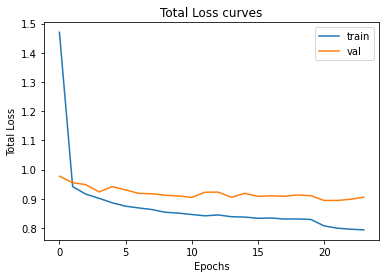

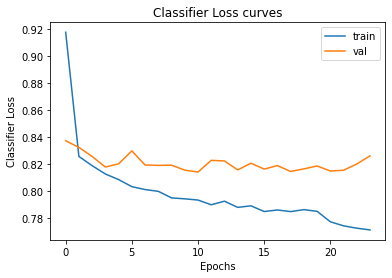

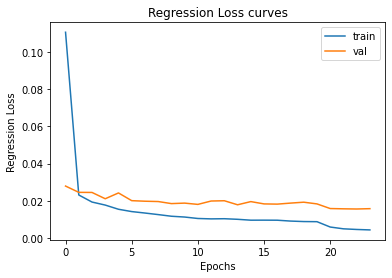

In [ ]:
# RUN THIS CELL TO VISUALIZE LOSSES OVER TRAINING
import matplotlib.pyplot as plt

train_losses = np.load('train_losses.npy')
val_losses = np.load('val_losses.npy')

plt.figure()
epochs = np.arange(24)
plt.plot(epochs, [l[0] for l in train_losses])
plt.plot(epochs, [l[0] for l in val_losses])
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.title('Total Loss curves')

plt.legend(['train', 'val']) 

plt.figure()
plt.plot(epochs, [l[1] for l in train_losses])
plt.plot(epochs, [l[1] for l in val_losses])
plt.xlabel('Epochs')
plt.ylabel('Classifier Loss')
plt.title('Classifier Loss curves')

plt.legend(['train', 'val']) 

plt.figure()
plt.plot(epochs, [l[2] for l in train_losses])
plt.plot(epochs, [l[2] for l in val_losses])
plt.xlabel('Epochs')
plt.ylabel('Regression Loss')
plt.title('Regression Loss curves')

plt.legend(['train', 'val']) 
plt.show()

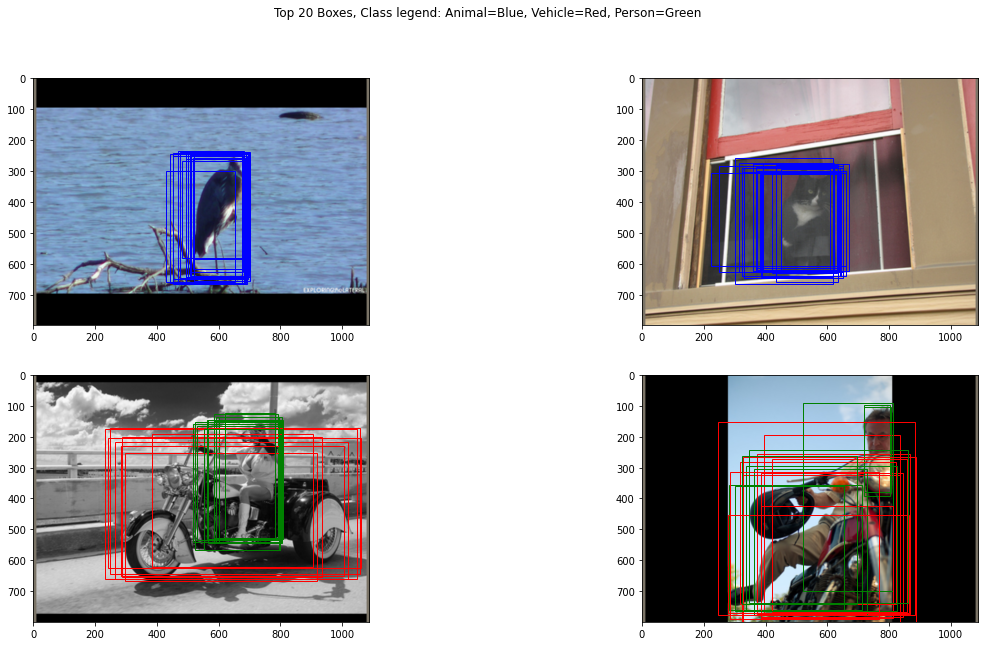

In [ ]:
# PLOT OF TOP 20 PROPOSALS FOR SELECTED IMAGES
import logging
from matplotlib.patches import Rectangle

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
val_loader = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn)
train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)
plt.figure(figsize=(20, 10))
cmap = {1: 'r', 2: 'g', 3: 'b'}

model.eval()

with torch.no_grad():
  for batch in val_loader:
    keep_topK=200
    img_batch, _, _ = batch
    img_batch = img_batch.to(device)
    # Take the features from the backbone
    backout = model.backbone(img_batch.float())
    # The RPN implementation takes as first argument the following image list
    im_lis = ImageList(img_batch.float(), [(800, 1088)]*img_batch.shape[0])
    # Then we pass the image list and the backbone output through the rpn
    rpnout = model.rpn(im_lis, backout)

    #The final output is
    # A list of proposal tensors: list:len(bz){(keep_topK,4)}
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
    
    # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
    fpn_feat_list= list(backout.values())
    feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list, proposals)
    class_logits, box_pred = model(feature_vectors)

    bz = len(proposals)
    per_image_proposals = proposals[0].shape[0]
    for b in range(bz):
      img_to_display = transforms.functional.normalize(img_batch[b],[-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225], inplace=False).permute(1,2,0)
      ax = plt.subplot(2, 2, b+1)
      ax.imshow(img_to_display.cpu())
      proposals_batch = proposals[b].cpu().numpy()
      logits_batch = class_logits[b*per_image_proposals:(b+1)*per_image_proposals,:].cpu().numpy()
      regr_batch = box_pred[b*per_image_proposals:(b+1)*per_image_proposals,:].cpu().numpy()

      scores = np.max(logits_batch, axis=1)
      labels = np.argmax(logits_batch, axis=1)
      idx_to_keep = labels > 0
      scores = scores[idx_to_keep]
      boxes = regr_batch[idx_to_keep]
      labels = labels[idx_to_keep]
      proposals_batch = proposals_batch[idx_to_keep]
      boxes_decoded = np.zeros((len(labels), 4))
      for i in range(len(labels)):
        l = labels[i]
        boxes_decoded[i,:] = boxes[i,(l-1)*4:l*4]
      boxes = output_decoding(boxes_decoded, proposals_batch)
      # clip boundaries
      boxes[boxes[:,0] < 0, 0] = 0
      boxes[boxes[:,1] < 0, 1] = 0
      boxes[boxes[:,2] > 1088, 2] = 1088
      boxes[boxes[:,3] > 800, 3] = 800
      K = min(20, len(scores))
      sorted_idx = np.argsort(scores)[::-1]
      top_k_idx = sorted_idx[:K]
      scores = scores[top_k_idx]
      boxes = boxes[top_k_idx,:]
      labels = labels[top_k_idx]

      for j in range(K):
        w = boxes[j, 2]-boxes[j,0]
        h = boxes[j,3]-boxes[j,1]
        rect = Rectangle((boxes[j,0], boxes[j,1]), w, h, edgecolor=cmap[labels[j]], facecolor=None, fill=False)
        ax.add_patch(rect)

    break
plt.suptitle("Top 20 Boxes, Class legend: Animal=Blue, Vehicle=Red, Person=Green")
plt.show()
logger.setLevel(old_level)

In [ ]:
# REPORT OF FINAL VALIDATION MAP AND APs
predictions = []
targets = []
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn)
keep_topK = 200
with torch.no_grad():
  for batch in val_loader:
    img_batch, label_batch, bbox_batch = batch
    img_batch = img_batch.to(device)
    # Take the features from the backbone
    backout = model.backbone(img_batch.float())
    # The RPN implementation takes as first argument the following image list
    im_lis = ImageList(img_batch.float(), [(800, 1088)]*img_batch.shape[0])
    # Then we pass the image list and the backbone output through the rpn
    rpnout = model.rpn(im_lis, backout)

    #The final output is
    # A list of proposal tensors: list:len(bz){(keep_topK,4)}
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
    
    # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
    fpn_feat_list= list(backout.values())
    feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list, proposals)
    class_logits, box_pred = model(feature_vectors)
    boxes, scores, labels = model.postprocess_detections(class_logits, box_pred, proposals, conf_thresh = 0.8, keep_num_preNMS=50, keep_num_postNMS=5)
    prediction = np.concatenate([np.expand_dims(scores[0], axis=1), np.expand_dims(labels[0], axis=1), boxes[0]], axis=1)
    tgt = np.concatenate([np.expand_dims(label_batch[0], axis=1), bbox_batch[0]], axis=1)
    predictions.append(prediction)
    targets.append(tgt)
map, aps = mean_average_precision(predictions, targets)

print("Validation mAP: " + str(map))
print("Validation Vehicle AP: " + str(aps[0]))
print("Validation Person AP: " + str(aps[1]))
print("Validation Animal AP: " + str(aps[2]))

Validation mAP: 0.6587364552905873
Validation Vehicle AP: 0.6501792435958951
Validation Person AP: 0.6169522176324322
Validation Animal AP: 0.7090779046434347


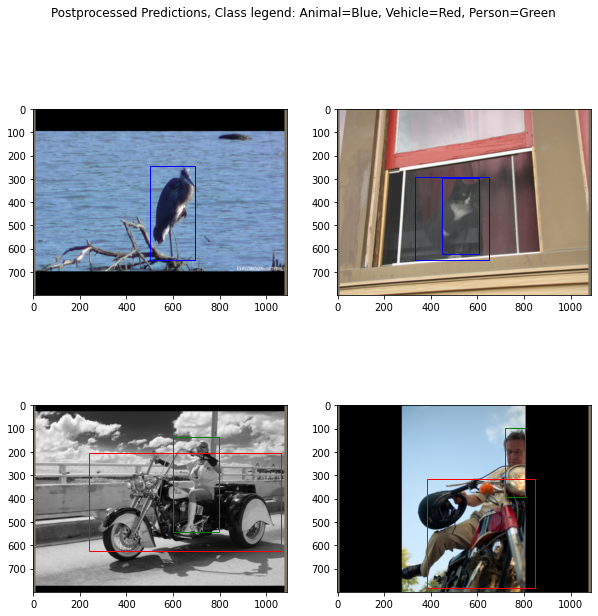

In [ ]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
val_loader = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn)
model.eval()
plt.figure(figsize=(10, 10))
with torch.no_grad():
  for batch in val_loader:
    keep_topK=200
    img_batch, _, _ = batch
    img_batch = img_batch.to(device)
    # Take the features from the backbone
    backout = model.backbone(img_batch.float())
    # The RPN implementation takes as first argument the following image list
    im_lis = ImageList(img_batch.float(), [(800, 1088)]*img_batch.shape[0])
    # Then we pass the image list and the backbone output through the rpn
    rpnout = model.rpn(im_lis, backout)
        
    #The final output is
    # A list of proposal tensors: list:len(bz){(keep_topK,4)}
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]

    # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
    fpn_feat_list= list(backout.values())
    feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list, proposals)
    class_logits, box_pred = model(feature_vectors)
    post_NMS_boxes_per_image = 5
    boxes, _, labels = model.postprocess_detections(class_logits, box_pred, proposals, conf_thresh = 0.8, keep_num_preNMS=50, keep_num_postNMS=post_NMS_boxes_per_image)

    bz = len(proposals)
    per_image_proposals = proposals[0].shape[0]
    for b in range(bz):
      img_to_display = transforms.functional.normalize(img_batch[b],[-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225], inplace=False).permute(1,2,0)
      ax = plt.subplot(2, 2, b+1)
      ax.imshow(img_to_display.cpu())
      boxes_batch = boxes[b]
      labels_batch = labels[b]

      for j in range(len(labels_batch)):
        w = boxes_batch[j, 2]-boxes_batch[j,0]
        h = boxes_batch[j,3]-boxes_batch[j,1]
        rect = Rectangle((boxes_batch[j,0], boxes_batch[j,1]), w, h, edgecolor=cmap[labels_batch[j]], facecolor=None, fill=False)
        ax.add_patch(rect)

    break
plt.suptitle("Postprocessed Predictions, Class legend: Animal=Blue, Vehicle=Red, Person=Green")
plt.show()
logger.setLevel(old_level)